### Training Word2vec

In [1]:
CBOW_N_WORDS = 4
SKIPGRAM_N_WORDS = 4

MIN_WORD_FREQUENCY = 50
MAX_SEQUENCE_LENGTH = 256

EMBED_DIMENSION = 300
EMBED_MAX_NORM = 1

In [3]:
import torch.nn as nn

#from utils.constants import EMBED_DIMENSION, EMBED_MAX_NORM

class SkipGram_Model(nn.Module):
  
    def __init__(self, vocab_size: int):
        super(SkipGram_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = self.linear(x)
        return x
model=SkipGram_Model(4099)

In [4]:
import os
import yaml
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR



def get_model_class(model_name: str):
    if model_name == "skipgram":
        return SkipGram_Model
    else:
        raise ValueError("Choose model_name from:  skipgram")
        return


def get_optimizer_class(name: str):
    if name == "Adam":
        return optim.Adam
    else:
        raise ValueError("Choose optimizer from: Adam")
        return
    

def get_lr_scheduler(optimizer, total_epochs: int, verbose: bool = True):
    """
    Scheduler to linearly decrease learning rate, 
    so thatlearning rate after the last epoch is 0.
    """
    lr_lambda = lambda epoch: (total_epochs - epoch) / total_epochs
    lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda, verbose=verbose)
    return lr_scheduler


def save_config(config: dict, model_dir: str):
    """Save config file to `model_dir` directory"""
    config_path = os.path.join(model_dir, "config.yaml")
    with open(config_path, "w") as stream:
        yaml.dump(config, stream)
        
        
def save_vocab(vocab, model_dir: str):
    """Save vocab file to `model_dir` directory"""
    vocab_path = os.path.join(model_dir, "vocab.pt")
    torch.save(vocab, vocab_path)

In [6]:
import torch
from functools import partial
from torch.utils.data import DataLoader
from torchtext.data import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import WikiText2, WikiText103



def get_english_tokenizer():
   
    tokenizer = get_tokenizer("basic_english", language="en")
    return tokenizer


def get_data_iterator(ds_name, ds_type, data_dir):
    if ds_name == "WikiText2":
        data_iter = WikiText2(root=data_dir, split=(ds_type))
    elif ds_name == "WikiText103":
        data_iter = WikiText103(root=data_dir, split=(ds_type))
    else:
        raise ValueError("Choose dataset from: WikiText2, WikiText103")
    data_iter = to_map_style_dataset(data_iter)
    return data_iter


def build_vocab(data_iter, tokenizer):
    
    vocab = build_vocab_from_iterator(
        map(tokenizer, data_iter),
        specials=["<unk>"],
        min_freq=MIN_WORD_FREQUENCY,
    )
    vocab.set_default_index(vocab["<unk>"])
    return vocab





def collate_skipgram(batch, text_pipeline):
    """
    Collate_fn for Skip-Gram model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.
    
    Context is represented as N=SKIPGRAM_N_WORDS past words 
    and N=SKIPGRAM_N_WORDS future words.
    
    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.
    
    Each element in `batch_input` is a middle word.
    Each element in `batch_output` is a context word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < SKIPGRAM_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            for output in outputs:
                batch_input.append(input_)
                batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output


def get_dataloader_and_vocab(
    model_name, ds_name, ds_type, data_dir, batch_size, shuffle, vocab=None
):

    data_iter = get_data_iterator(ds_name, ds_type, data_dir)
    tokenizer = get_english_tokenizer()

    if not vocab:
        vocab = build_vocab(data_iter, tokenizer)
        
    text_pipeline = lambda x: vocab(tokenizer(x))

    if model_name == "skipgram":
        collate_fn = collate_skipgram
    else:
        raise ValueError("Choose model from: skipgram")

    dataloader = DataLoader(
        data_iter,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
    )
    return dataloader, vocab

In [7]:
import os
import numpy as np
import json
import torch


class Trainer:
    """Main class for model training"""
    
    def __init__(
        self,
        model,
        epochs,
        train_dataloader,
        train_steps,
        val_dataloader,
        val_steps,
        checkpoint_frequency,
        criterion,
        optimizer,
        lr_scheduler,
        device,
        model_dir,
        model_name,
    ):  
        self.model = model
        self.epochs = epochs
        self.train_dataloader = train_dataloader
        self.train_steps = train_steps
        self.val_dataloader = val_dataloader
        self.val_steps = val_steps
        self.criterion = criterion
        self.optimizer = optimizer
        self.checkpoint_frequency = checkpoint_frequency
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.model_dir = model_dir
        self.model_name = model_name

        self.loss = {"train": [], "val": []}
        self.model.to(self.device)

    def train(self):
        for epoch in range(self.epochs):
            self._train_epoch()
            self._validate_epoch()
            print(
                "Epoch: {}/{}, Train Loss={:.5f}, Val Loss={:.5f}".format(
                    epoch + 1,
                    self.epochs,
                    self.loss["train"][-1],
                    self.loss["val"][-1],
                )
            )

            self.lr_scheduler.step()

            if self.checkpoint_frequency:
                self._save_checkpoint(epoch)

    def _train_epoch(self):
        self.model.train()
        running_loss = []

        for i, batch_data in enumerate(self.train_dataloader, 1):
            inputs = batch_data[0].to(self.device)
            labels = batch_data[1].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())

            if i == self.train_steps:
                break

        epoch_loss = np.mean(running_loss)
        self.loss["train"].append(epoch_loss)

    def _validate_epoch(self):
        self.model.eval()
        running_loss = []

        with torch.no_grad():
            for i, batch_data in enumerate(self.val_dataloader, 1):
                inputs = batch_data[0].to(self.device)
                labels = batch_data[1].to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss.append(loss.item())

                if i == self.val_steps:
                    break

        epoch_loss = np.mean(running_loss)
        self.loss["val"].append(epoch_loss)

    def _save_checkpoint(self, epoch):
        """Save model checkpoint to `self.model_dir` directory"""
        epoch_num = epoch + 1
        if epoch_num % self.checkpoint_frequency == 0:
            model_path = "checkpoint_{}.pt".format(str(epoch_num).zfill(3))
            model_path = os.path.join(self.model_dir, model_path)
            torch.save(self.model, model_path)

    def save_model(self):
        """Save final model to `self.model_dir` directory"""
        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)

    def save_loss(self):
        """Save train/val loss as json file to `self.model_dir` directory"""
        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)

In [11]:
import argparse
import yaml
import os
import torch
import torch.nn as nn
from torchdata.datapipes.iter import IterableWrapper




def train(config):
    os.makedirs(config["model_dir"])
    
    train_dataloader, vocab = get_dataloader_and_vocab(
        model_name=config["model_name"],
        ds_name=config["dataset"],
        ds_type="train",
        data_dir=config["data_dir"],
        batch_size=config["train_batch_size"],
        shuffle=config["shuffle"],
        vocab=None,
    )

    val_dataloader, _ = get_dataloader_and_vocab(
        model_name=config["model_name"],
        ds_name=config["dataset"],
        ds_type="valid",
        data_dir=config["data_dir"],
        batch_size=config["val_batch_size"],
        shuffle=config["shuffle"],
        vocab=vocab,
    )

    vocab_size = len(vocab.get_stoi())
    print(f"Vocabulary size: {vocab_size}")

    model_class = get_model_class(config["model_name"])
    model = model_class(vocab_size=vocab_size)
    criterion = nn.CrossEntropyLoss()

    optimizer_class = get_optimizer_class(config["optimizer"])
    optimizer = optimizer_class(model.parameters(), lr=config["learning_rate"])
    lr_scheduler = get_lr_scheduler(optimizer, config["epochs"], verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    trainer = Trainer(
        model=model,
        epochs=config["epochs"],
        train_dataloader=train_dataloader,
        train_steps=config["train_steps"],
        val_dataloader=val_dataloader,
        val_steps=config["val_steps"],
        criterion=criterion,
        optimizer=optimizer,
        checkpoint_frequency=config["checkpoint_frequency"],
        lr_scheduler=lr_scheduler,
        device=device,
        model_dir=config["model_dir"],
        model_name=config["model_name"],
    )

    trainer.train()
    print("Training finished.")

    trainer.save_model()
    trainer.save_loss()
    save_vocab(vocab, config["model_dir"])
    save_config(config, config["model_dir"])
    print("Model artifacts saved to folder:", config["model_dir"])
    
    
if __name__ == '__main__':
    '''parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, required=True, help='path to yaml config')
    args = parser.parse_args()'''
    
    with open('config.yaml', 'r') as stream:
        config = yaml.safe_load(stream)
    train(config)

Vocabulary size: 4099
Adjusting learning rate of group 0 to 2.5000e-02.


In [ ]:

import numpy as np
import pandas as pd
import torch
import sys

from sklearn.manifold import TSNE
import plotly.graph_objects as go

#model=torch.load("/content/weights/cbow_WikiText2'/model.pt")
model.load_state_dict(torch.load("/content/drive/MyDrive/DS504/model1.pth"))
vocab = torch.load("/content/drive/MyDrive/DS504/vocab.pth")
#Getting Embeddings

embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# normalization
norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape
#Visualization with t-SNE
# get embeddings
embeddings_df = pd.DataFrame(embeddings)

# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_df_trans = tsne.fit_transform(embeddings_df)
embeddings_df_trans = pd.DataFrame(embeddings_df_trans)

# get token order
embeddings_df_trans.index = vocab.get_itos()

# if token is a number
is_numeric = embeddings_df_trans.index.str.isnumeric()
color = np.where(is_numeric, "green", "black")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embeddings_df_trans[0],
        y=embeddings_df_trans[1],
        mode="text",
        text=embeddings_df_trans.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)
fig.write_html("/content/drive/MyDrive/DS504/word2vec_visualization.html")
#Find Similar Words
def get_top_similar(word: str, topN: int = 10):
    word_id = vocab[word]
    if word_id == 0:
        print("Out of vocabulary word")
        return

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    dists = np.matmul(embeddings_norm, word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        sim_word = vocab.lookup_token(sim_word_id)
        topN_dict[sim_word] = dists[sim_word_id]
    return topN_dict
for word, sim in get_top_similar("queen").items():
    print("{}: {:.3f}".format(word, sim))
 


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


hms: 0.507
victoria: 0.506
king: 0.502
frederick: 0.497
charles: 0.494
elizabeth: 0.485
edward: 0.482
george: 0.471
daughter: 0.461
son: 0.431


In [ ]:

 
#Vector Equations
emb1 = embeddings[vocab["man"]]
emb2 = embeddings[vocab["woman"]]
emb3 = embeddings[vocab["queen"]]

emb4 = emb1 - emb2 + emb3
emb4_norm = (emb4 ** 2).sum() ** (1 / 2)
emb4 = emb4 / emb4_norm

emb4 = np.reshape(emb4, (len(emb4), 1))
dists = np.matmul(embeddings_norm, emb4).flatten()

top5 = np.argsort(-dists)[:5]

for word_id in top5:
    print("{}: {:.3f}".format(vocab.lookup_token(word_id), dists[word_id]))

queen: 0.731
king: 0.438
man: 0.426
edward: 0.390
hms: 0.371


In [ ]:
#Vector Equations
emb1 = embeddings[vocab["milk"]]
emb2 = embeddings[vocab["pant"]]
emb3 = embeddings[vocab["tea"]]

emb4 = emb1 - emb2 + emb3
emb4_norm = (emb4 ** 2).sum() ** (1 / 2)
emb4 = emb4 / emb4_norm

emb4 = np.reshape(emb4, (len(emb4), 1))
dists = np.matmul(embeddings_norm, emb4).flatten()

top5 = np.argsort(-dists)[:5]

for word_id in top5:
    print("{}: {:.3f}".format(vocab.lookup_token(word_id), dists[word_id]))

<unk>: 1.000
bone: 0.405
simple: 0.386
bishop: 0.361
jean: 0.357


In [ ]:
torch.save(model.state_dict(), "model1.pth")
torch.save("vocab.pth")

### Pretrained Word2vec


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


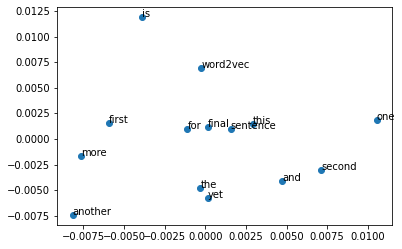

In [ ]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
            ['this', 'is', 'the', 'second', 'sentence'],
            ['yet', 'another', 'sentence'],
            ['one', 'more', 'sentence'],
            ['and', 'the', 'final', 'sentence']]
# train model
model_1 = Word2Vec(sentences, size=300, min_count=1)

# fit a 2d PCA model to the vectors
X = model_1[model_1.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model_1.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [ ]:
model_1.most_similar(positive=['final'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('another', 0.12716959416866302),
 ('one', 0.06272583454847336),
 ('sentence', 0.060022421181201935),
 ('is', 0.038779787719249725),
 ('the', 0.0308675616979599),
 ('second', 0.01855158619582653),
 ('for', 0.013133496046066284),
 ('and', 0.003790736198425293),
 ('more', 0.0032859928905963898),
 ('yet', -0.008202701807022095)]

### Sentiment analysis using word2vec

In [ ]:

import sys
import nltk.data,logging, re
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
import nltk
nltk.download('punkt')
def reviewToSentences(review, tokenizer, remove_stopwords=False):
    rawSentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in rawSentences:
        if len(raw_sentence) > 0:
            sentences.append(reviewToWordList(raw_sentence, remove_stopwords))
    return sentences

def reviewToWordList(review, remove_stopwords=False):
    reviewText = BeautifulSoup(review).get_text() # Remove HTML
    reviewText = re.sub("[^a-zA-Z]"," ", reviewText)    # Remove non-letters
    words = reviewText.lower().split()    # Convert words to lower case and split them

    # 4. Optionally remove stop words (
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return(words)

# Function to average all of the word vectors in a given paragraph
def makeFeatureVec(words, model, num_features):

    # initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")

    nwords = 0.

    # Index2word is a list that contains the names of the words in
    # the model's vocabulary. Convert it to a set, for speed
    index2word_set = set(model.wv.index2word)

    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])

    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

# Given a set of reviews (each one a list of words), calculate the average feature vector for each one and return a 2D numpy array
def getAvgFeatureVecs(reviews, model, num_features):
    # Initialize a counter
    counter = 0.

    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")

    # Loop through the reviews
    for review in reviews:

        if counter%1000. == 0.:
            print ("Review %d of %d" % (counter, len(reviews)))

        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, num_features)
        counter = counter + 1.

    return reviewFeatureVecs

def getCleanReviews(reviews):
    clean_reviews = []
    for review in reviews["review"]:
        clean_reviews.append(reviewToWordList(review, remove_stopwords=True))
    return clean_reviews


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Read data from files
train = pd.read_csv( '/content/drive/MyDrive/DS504/labeledTrainData.tsv', header=0, delimiter="\t", quoting=3 )
test = pd.read_csv( '/content/drive/MyDrive/DS504/testData.tsv', header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "/content/drive/MyDrive/DS504/unlabeledTrainData.tsv", header=0,  delimiter="\t", quoting=3 )

    # Verify the number of reviews that were read (100,000 in total)
print( "Read %d labeled train reviews, %d labeled test reviews, " \
          "and %d unlabeled reviews\n" % (train["review"].size, test["review"].size, unlabeled_train["review"].size ))

    # Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = []  # Initialize an empty list of sentences

print ("Parsing sentences from training set")
for review in train["review"]:
        sentences += reviewToSentences(review, tokenizer)

print ("Parsing sentences from unlabeled set")
for review in unlabeled_train["review"]:
        sentences += reviewToSentences(review, tokenizer)

    # Set parameters and train the word2vec model
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', \
                        level=logging.INFO)

    # Set values for various parameters
num_features = 300    # Word vector dimensionality
min_word_count = 40   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

    # Initialize and train the model (this will take some time)
print ("Training Word2Vec model...")
model=Word2Vec(sentences,workers=num_workers,size=num_features,min_count=min_word_count,window=context,sample=downsampling,seed=1)

    # If you don't plan to train the model any further, calling
    # init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

    #SAVE THE MODEL
model_name = "300features_40minwords_10context"
model.save(model_name)

   

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews

Parsing sentences from training set
Parsing sentences from unlabeled set


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning:

"b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning:

"http://www.youtube.com/watch?v=a0KSqelmgN8"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning:

"http://jake-weird.blogspot.com/2007/08/beneath.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.



Training Word2Vec model...


In [ ]:
 # TEST THE MODEL
model.doesnt_match("man woman child kitchen".split())
model.doesnt_match("france england germany berlin".split())
model.doesnt_match("paris berlin london austria".split())
model.most_similar("man")
model.most_similar("queen")
model.most_similar("awful")
nltk.download('stopwords')
    # Create average vectors for the training and test sets
print ("Creating average feature vecs for training reviews")
trainDataVecs = getAvgFeatureVecs( getCleanReviews(train), model, num_features )

print ("Creating average feature vecs for test reviews")
testDataVecs = getAvgFeatureVecs( getCleanReviews(test), model, num_features )

    # Fit a random forest to the training set, then make predictions
forest = RandomForestClassifier( n_estimators = 100 )

print ("Fitting a random forest to labeled training data...")
forest = forest.fit( trainDataVecs, train["sentiment"] )

    # Test & extract results
result = forest.predict( testDataVecs )

    # Write the test results
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv( "/content/OUTPUT_Word2Vec_AverageVectors.csv", index=False, quoting=3 )
print ("Wrote Word2Vec_AverageVectors.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).

/usr/local/lib/python3.7/dist-packages/ipyker

Creating average feature vecs for training reviews
Review 0 of 25000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Creating average feature vecs for test reviews
Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 

### Dependency Parsing

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

In [4]:
import os
java_path = "C:/Program Files/Java/jdk1.8.0_161/bin/java.exe"
os.environ['JAVAHOME'] = java_path

In [ ]:
from nltk.parse.stanford import StanfordDependencyParser
from nltk.parse.stanford import StanfordDependencyParser



sentence = 'Deemed universities charge huge fees'

# Initialize StanfordDependency Parser from the path
parser = StanfordDependencyParser(path_to_jar = "D:\DS504 Natural Language Processing\DS504\stanford-corenlp-4.5.1\stanford-corenlp-4.5.1.jar", path_to_models_jar =  "D:\DS504 Natural Language Processing\DS504\stanford-corenlp-4.5.1\stanford-corenlp-4.5.1-models.jar",    )

# Parse the sentence
result = parser.raw_parse(sentence)
dependency = result.__next__()


print ("{:<15} | {:<10} | {:<10} | {:<15} | {:<10}".format('Head', 'Head POS','Relation','Dependent', 'Dependent POS'))
print ("-" * 75)
  
# Use dependency.triples() to extract the dependency triples in the form
# ((head word, head POS), relation, (dependent word, dependent POS))  
for dep in list(dependency.triples()):
  print ("{:<15} | {:<10} | {:<10} | {:<15} | {:<10}"
         .format(str(dep[0][0]),str(dep[0][1]), str(dep[1]), str(dep[2][0]),str(dep[2][1])))

In [ ]:
# importing networkx
import networkx as nx
import matplotlib.pyplot as plt
# Using reverse() to reverse the direction of edges as nx_graph() returns inverted edges
G = dependency.nx_graph().reverse()
# nx_graph() returns numeric node labels starting from 1
# Create a dictionary to map numeric nodes and words in the sentence
words = sentence.split(" ")
labels = {index + 1: words[index] for index in range(len(words))}
nx.draw(G, with_labels=True, labels=labels, node_size=2500, node_color='#B5EAD7', font_size=10)

In [ ]:
!pip install graphviz
from graphviz import Source
dot_def = dependency.to_dot()
'''
The below lines require graphviz executables to be installed to your system. If that does not work, print the dot_def object and paste the output on http://graphs.grevian.org/graph/
'''
source = Source(dot_def, filename="dependency_graph", format="png")
source.view()